# 1. Data loading and preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import Perceptron as SklearnPerceptron, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler


# Handle data
def load_data(filepath):
    features = []
    labels = []
    
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) > 1: 
                labels.append(int(parts[0]))  # First column is the label
                feature_vector = [float(val.split(":")[1]) for val in parts[1:]]  
                features.append(feature_vector)
    
    # Ensure all rows have the same number of features
    max_len = max(len(f) for f in features)
    features_padded = [f + [0] * (max_len - len(f)) for f in features]  # Pad with zeros
    
    X = np.array(features_padded)
    y = np.array(labels)
    return X, y

# Load the dataset
X, y = load_data('diabetes_scale.txt')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 2. Train Perceptron model

In [2]:
# Train Perceptron model
perceptron = SklearnPerceptron(max_iter=1000, eta0=0.05, random_state=42)
perceptron.fit(X_train_scaled, y_train)

# Make predictions and evaluate Perceptron
y_pred_perceptron = perceptron.predict(X_test_scaled)
accuracy_perceptron = accuracy_score(y_test, y_pred_perceptron)
precision = precision_score(y_test, y_pred_perceptron)
recall = recall_score(y_test, y_pred_perceptron)
f1 = f1_score(y_test, y_pred_perceptron)
conf_matrix = confusion_matrix(y_test, y_pred_perceptron)

print(f"Perceptron Accuracy: {accuracy_perceptron * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")


Perceptron Accuracy: 63.64%
Precision: 0.69
Recall: 0.79
F1-Score: 0.74
Confusion Matrix:
[[20 35]
 [21 78]]


# 3. Train Logistic Regression model

In [3]:
# Train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Make predictions and evaluate Logistic Regression
y_pred_log_reg = log_reg.predict(X_test_scaled)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {accuracy_log_reg * 100:.2f}%")

# Perform cross-validation 
scores_log_reg = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (Logistic Regression): {np.mean(scores_log_reg) * 100:.2f}%")

Logistic Regression Accuracy: 75.32%
Cross-Validation Accuracy (Logistic Regression): 76.06%


# 4. Train and tune Random Forest model using RandomizedSearchCV

In [4]:
# Train and tune Random Forest model using RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_scaled, y_train)

# Evaluate Random Forest
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Best parameters: {random_search.best_params_}")
print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")
print(f"Best cross-validation accuracy: {random_search.best_score_ * 100:.2f}%")

# Feature importance
importances = best_rf.feature_importances_
for i, importance in enumerate(importances):
    print(f"Feature {i+1}: {importance:.4f}")

# ROC-AUC score for Random Forest
y_pred_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob_rf)
print(f"ROC-AUC Score (Random Forest): {roc_auc:.2f}")

# Evaluate other metrics for Random Forest
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Random Forest Precision: {precision_rf:.2f}")
print(f"Random Forest Recall: {recall_rf:.2f}")
print(f"Random Forest F1-Score: {f1_rf:.2f}")
print(f"Random Forest Confusion Matrix:\n{conf_matrix_rf}")

Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 10}
Random Forest Accuracy: 74.03%
Best cross-validation accuracy: 78.18%
Feature 1: 0.0663
Feature 2: 0.2978
Feature 3: 0.0712
Feature 4: 0.0592
Feature 5: 0.0727
Feature 6: 0.1725
Feature 7: 0.1057
Feature 8: 0.1546
ROC-AUC Score (Random Forest): 0.84
Random Forest Precision: 0.80
Random Forest Recall: 0.79
Random Forest F1-Score: 0.80
Random Forest Confusion Matrix:
[[36 19]
 [21 78]]


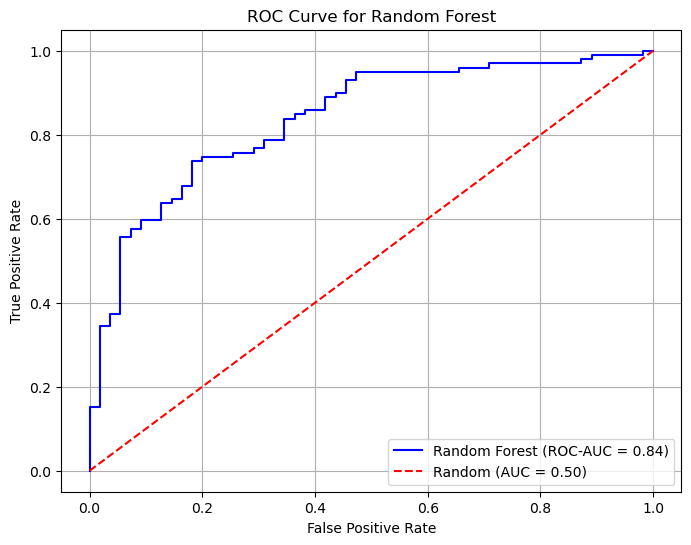

In [5]:
# ROC curve
y_pred_prob_rf = best_rf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Random Forest (ROC-AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()